In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from tqdm.auto import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
# import plotly.express as px
from tensorflow.keras import layers
from pickle import dump, load
from pathlib import Path

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
config = {
    "big_shape": (56,56),
    "kernel_size": 3,
    "filters":32,
    "epochs": 140
}

In [4]:
wandb.init(project = "TFM_PruebasInv",config = config, mode = "disabled")
config = wandb.config


In [3]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()
Xtrain = Xtrain / 255
Xtest = Xtest / 255
Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)

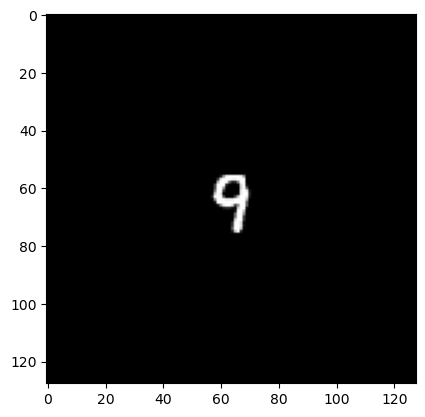

In [7]:
Xtrain_big = np.zeros((Xtrain.shape[0],128,128,1))
Xtrain_big[:,50:28+50,50:50+28] = Xtrain[:,:,:]

Xtest_big = np.zeros((Xtest.shape[0],128,128,1))
Xtest_big[:,50:50+28,50:50+28] = Xtest[:,:,:]

plt.imshow(Xtrain_big[520].squeeze(), cmap = "gray")
plt.show()

In [25]:
clasificador = tf.keras.models.Sequential([
    layers.Conv2D(config.filters, config.kernel_size, activation = "relu", padding = "same" ,input_shape = Xtrain_big[0].shape),#56x56
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation  = "softmax")
])

clasificador.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = clasificador.fit(Xtrain_big, Ytrain, batch_size=128, epochs=config.epochs, validation_data = (Xtest_big, Ytest), 
                           callbacks = [WandbMetricsLogger(log_freq="epochs"),
                                         WandbModelCheckpoint(filepath="clasificador", monitor = "val_accuracy", mode = "max", save_best_only = True, save_weights_only = True)])

Epoch 1/120
469/469 [==============================] - 21s 39ms/step - loss: 2.2724 - accuracy: 0.1628 - val_loss: 2.2194 - val_accuracy: 0.2121
Epoch 2/120
469/469 [==============================] - 18s 38ms/step - loss: 2.1565 - accuracy: 0.2221 - val_loss: 2.1031 - val_accuracy: 0.2301
Epoch 3/120
469/469 [==============================] - 18s 38ms/step - loss: 2.0696 - accuracy: 0.2462 - val_loss: 2.0401 - val_accuracy: 0.2473
Epoch 4/120
469/469 [==============================] - 18s 38ms/step - loss: 2.0211 - accuracy: 0.2695 - val_loss: 2.0008 - val_accuracy: 0.2811
Epoch 5/120
469/469 [==============================] - 18s 38ms/step - loss: 1.9840 - accuracy: 0.2948 - val_loss: 1.9682 - val_accuracy: 0.2787
Epoch 6/120
469/469 [==============================] - 18s 39ms/step - loss: 1.9500 - accuracy: 0.3067 - val_loss: 1.9310 - val_accuracy: 0.3149
Epoch 7/120
469/469 [==============================] - 18s 38ms/step - loss: 1.9170 - accuracy: 0.3227 - val_loss: 1.8977 - val_ac

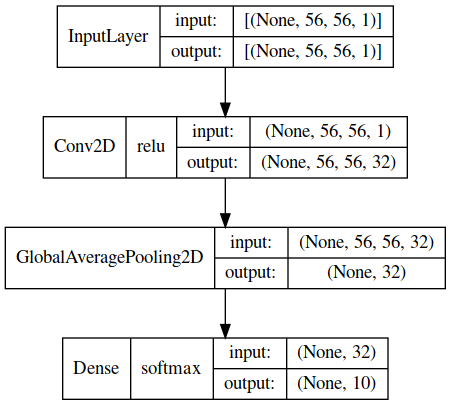

In [12]:
tf.keras.utils.plot_model(
    clasificador,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

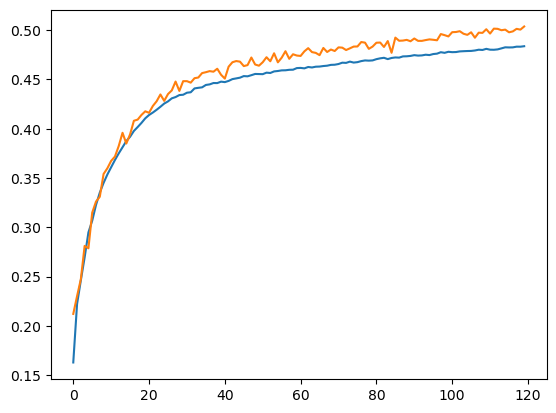

In [40]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

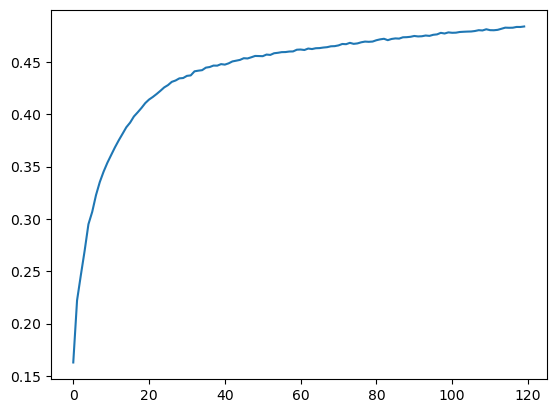

In [38]:
plt.plot(history.history["accuracy"])

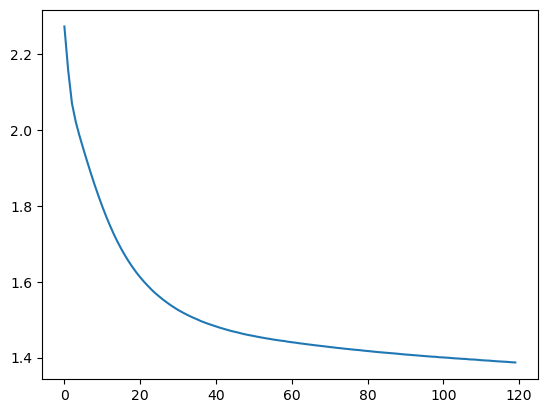

In [27]:
plt.plot(history.history["loss"])

In [20]:
# Guardar el Modelo
clasificador.save('clasificador_lit.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#clasificador = tf.keras.models.load_model('clasificador_inv_basico.h5')

In [ ]:
for layer in clasificador.layers:
    filtros = layer.get_weights()[0]
    for i in range(32):
        plt.imshow(filtros[:,:,0,i])
        plt.show()
    break




In [34]:
filtros[0].shape

(3, 3, 1, 32)

In [ ]:
def var_pos(X, desp_h, desp_v):
  X_big = np.zeros((X.shape[0],*big_shape,1))
  X_big[:,14+desp_v:14+28+desp_v,14+desp_h:14+28+desp_h] = X[:,:,:]
  return X_big

In [ ]:
def out_mapas(model,X):
  capas = model.layers
  salida = [X]

  for capa in capas:
    salida_capa = capa(salida[-1]).numpy()
    salida.append(salida_capa)
  
  return salida

# MÉTRICAS


In [ ]:
 
# desps_h = range(-7,8)
# desps_v = range(-7,8)
# metricas = {}
# mapas_caracteristicas = {}
 
# for desp_h in tqdm(desps_h):
#     for desp_v in tqdm(desps_v):
#         Xtrain_desplazado = var_pos(Xtrain, desp_h = desp_h, desp_v = desp_v)
#         Xtest_desplazado = var_pos(Xtest, desp_h = desp_h, desp_v = desp_v)
#         met_train = clasificador.evaluate(Xtrain_desplazado, Ytrain, batch_size=10, verbose=0, return_dict=True)
#         met_test = clasificador.evaluate(Xtest_desplazado, Ytest, batch_size=10, verbose=0, return_dict=True)
#         metricas[(desp_h, desp_v)] = {"Train":met_train, "Test":met_test}
        


In [ ]:
# Escribir 
# with open("metricas_traslacion_lit.pkl", "wb") as f:
#         dump(metricas, f)

# Leer
with open("metricas_traslacion_inv_basico.pkl", "rb") as f:
        metricas = load(f)


In [ ]:
df_metricas = pd.DataFrame.from_dict(metricas, orient="index").reset_index()
df_metricas.columns = ["desp_h","desp_v", "Train", "Test"]
df_metricas.head()

,desp_h,desp_v,Train,Test
0,-7,-7,"{'loss': 1.8137240409851074, 'accuracy': 0.358...","{'loss': 1.8081207275390625, 'accuracy': 0.361..."
1,-7,-6,"{'loss': 1.8137240409851074, 'accuracy': 0.358...","{'loss': 1.8081207275390625, 'accuracy': 0.361..."
2,-7,-5,"{'loss': 1.8137240409851074, 'accuracy': 0.358...","{'loss': 1.8081207275390625, 'accuracy': 0.361..."
3,-7,-4,"{'loss': 1.8137240409851074, 'accuracy': 0.358...","{'loss': 1.808120846748352, 'accuracy': 0.3616..."
4,-7,-3,"{'loss': 1.8137240409851074, 'accuracy': 0.358...","{'loss': 1.808120846748352, 'accuracy': 0.3616..."


In [ ]:
TrainLoss = []
TrainAccuracy = []
TestLoss = []
TestAccuracy = []

for key in metricas.keys():
    TrainLoss.append(metricas[key]["Train"]["loss"])
    TrainAccuracy.append(metricas[key]["Train"]["accuracy"])
    TestLoss.append(metricas[key]["Test"]["loss"])
    TestAccuracy.append(metricas[key]["Test"]["accuracy"])
    

In [ ]:
df_metricas["TrainLoss"] = TrainLoss
df_metricas["TrainAccuracy"] = TrainAccuracy
df_metricas["TestLoss"] = TestLoss
df_metricas["TestAccuracy"] = TestAccuracy

df_metricas = df_metricas.drop("Train", axis = 1)
df_metricas = df_metricas.drop("Test", axis = 1)

In [ ]:
df_metricas

,desp_h,desp_v,TrainLoss,TrainAccuracy,TestLoss,TestAccuracy
0,-7,-7,1.813724,0.358117,1.808121,0.3616
1,-7,-6,1.813724,0.358117,1.808121,0.3616
2,-7,-5,1.813724,0.358117,1.808121,0.3616
3,-7,-4,1.813724,0.358117,1.808121,0.3616
4,-7,-3,1.813724,0.358117,1.808121,0.3616
...,...,...,...,...,...,...
220,7,3,1.813724,0.358117,1.808121,0.3616
221,7,4,1.813724,0.358117,1.808121,0.3616
222,7,5,1.813724,0.358117,1.808121,0.3616
223,7,6,1.813724,0.358117,1.808121,0.3616


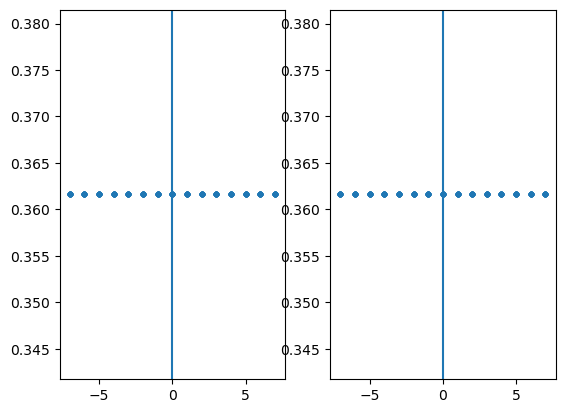

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(df_metricas["desp_h"], df_metricas["TestAccuracy"], '.')
axes[0].axvline(0)
axes[1].plot(df_metricas["desp_v"], df_metricas["TestAccuracy"], '.')
axes[1].axvline(0)
plt.show()

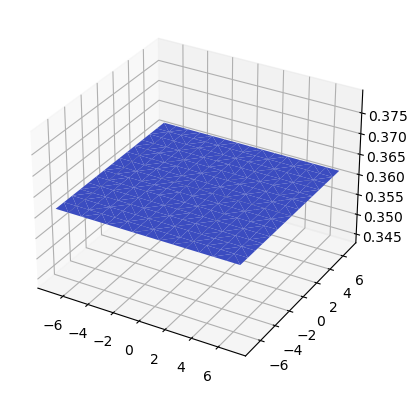

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(df_metricas["desp_h"], df_metricas["desp_v"], df_metricas["TestAccuracy"], cmap="coolwarm")
plt.savefig("surface", dpi = 300)
plt.show()

# MAPAS DE CARACTERÍSTICAS

In [ ]:
select = np.array([0,1,2,3,4,7,8,11,18,61]) # Una imagen con cada número
Xtest_selec = Xtest[select]
Ytest_selec = Ytest[select]

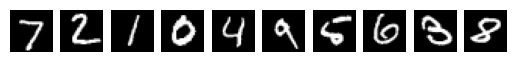

In [ ]:
fig, axes = plt.subplots(1,10,squeeze=False)
axes[0,0].set_ylabel("Xtest")
for i in range(10):
    axes[0,i].imshow(Xtest_selec[i].squeeze(), cmap="gray")
    axes[0,i].axis("off")
    

In [ ]:
mapas_caracteristicas = {}
desps_h = range(-7,8)
desps_v = range(-7,8)

for desp_h in tqdm(desps_h):
  for desp_v in tqdm(desps_v):
    Xtest_desplazado = var_pos(Xtest_selec, desp_h = desp_h, desp_v = desp_v)
    mapas_test = out_mapas(clasificador,Xtest_desplazado)
    mapas_caracteristicas[(desp_h, desp_v)] = mapas_test

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
for mp in mapas_caracteristicas[(-7,-7)]: print(mp.shape)

(10, 56, 56, 1)
(10, 56, 56, 32)
(10, 32)
(10, 10)


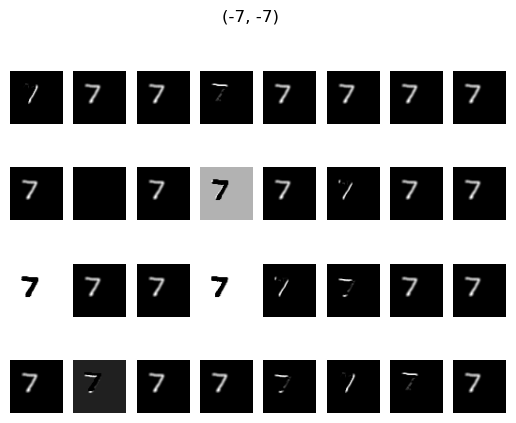

In [ ]:
for desps, outputs in mapas_caracteristicas.items():
    for image in range(len(outputs[1])):
        fig, axes = plt.subplots(4,8)
        axes = axes.flatten()
        for i in range(outputs[1][image].shape[-1]):
            axes[i].imshow(outputs[1][image,:,:,i].squeeze(), cmap="gray")
            axes[i].axis("off")
        plt.suptitle(desps)
        plt.show()
        break
    break
        
    

In [ ]:
desps_h = range(-7,8)
desps_v = range(-7,8)
dist_0 = {}
list_df = []
AllImages = {}

for image in Ytest_selec:
    for filtro in range(32):
        for desp_h in desps_h:
            for desp_v in tqdm(desps_v):
                dist = np.array(mapas_caracteristicas[0,0][1][image,:,:,filtro]) - np.array(mapas_caracteristicas[desp_h,desp_v][1][image,:,:,filtro])
                dist_0[(desp_h, desp_v)] = round(np.sum(np.abs(dist)),2)
        df = pd.DataFrame.from_dict(dist_0, orient="index")
        list_df.append(df)
    TablaCompleta = pd.concat(list_df, axis = 1)
    AllImages[image] = TablaCompleta
    break

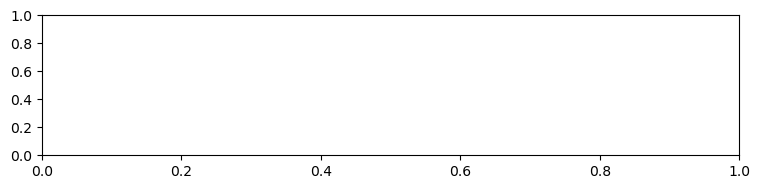

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

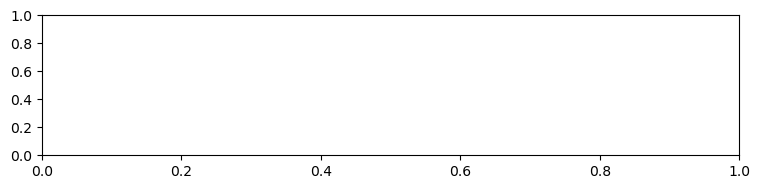

In [ ]:
plt.figure(figsize=(9,4))
plt.subplot(2,1,1)
plt.show(mapas_caracteristicas[7,7][2][1])
plt.axis("off")
plt.subplot(2,1,2)
plt.show(mapas_caracteristicas[0,0][2][1])
plt.axis("off")
plt.show()

In [ ]:
# plt.figure(figsize=(9,4))
# plt.subplot(2,1,1)
# plt.matshow(np.repeat(mapas_caracteristicas[7,7][2][1], 50, axis=0), fignum=0)
# plt.axis("off")
# plt.subplot(2,1,2)
# plt.matshow(np.repeat(mapas_caracteristicas[0,0][2][1], 50, axis=0), fignum=0)
# plt.axis("off")
# plt.show()